In [1]:
%%capture

%pip install "tensorflow==2.15.*"
%pip install "tensorflow-text==2.15.*"
%pip install "tf-models-official==2.15.*"
%pip install "tf-keras==2.15.*"
%pip install keras-tuner

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
# Load datasets

dataset_name = 'ccc-bert-250325-80'

autotune = tf.data.AUTOTUNE
batch_size = 32
seed = 42

ds_dir = os.path.join('/kaggle/input', dataset_name)

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(ds_dir, 'train'),
    batch_size=batch_size)

def oneHotLabels(x, y): return x, tf.one_hot(y, depth=len(raw_train_ds.class_names))

train_ds = raw_train_ds.map(oneHotLabels).cache().prefetch(buffer_size=autotune)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(ds_dir, 'validate'),
    batch_size=batch_size)

val_ds = raw_val_ds.map(oneHotLabels).cache().prefetch(buffer_size=autotune)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(ds_dir, 'test'),
    batch_size=batch_size)

test_ds = raw_test_ds.map(oneHotLabels).cache().prefetch(buffer_size=autotune)

Found 937 files belonging to 4 classes.
Found 119 files belonging to 4 classes.
Found 120 files belonging to 4 classes.


In [4]:
# Build BERT neural net

epochs = 40

def build_model(hp):
    tfhub_handle_encoder = 'https://tfhub.dev/google/experts/bert/pubmed/2'
    tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
    
    # Hyperparameter tuning
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    l2_rate = hp.Float('l2_rate', min_value=0.0001, max_value=0.01, step=5, sampling='log')
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-4, step=5, sampling='log')
    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(dropout_rate)(net)
    net = tf.keras.layers.Dense(4, activation='softmax',
                                kernel_regularizer=tf.keras.regularizers.l2(l2_rate),
                                name='classifier')(net)
    
    loss = tf.keras.losses.CategoricalCrossentropy()
    metrics = tf.metrics.CategoricalAccuracy()
    
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)
    
    optimizer = optimization.create_optimizer(
        init_lr=learning_rate,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        optimizer_type='adamw')
    
    model = tf.keras.Model(text_input, net)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [5]:
epochs = 40

def define_model(dropout_rate, l2_rate, learning_rate):
    tfhub_handle_encoder = 'https://tfhub.dev/google/experts/bert/pubmed/2'
    tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(dropout_rate)(net)
    net = tf.keras.layers.Dense(4, activation='softmax',
                                kernel_regularizer=tf.keras.regularizers.l2(l2_rate),
                                name='classifier')(net)
    
    loss = tf.keras.losses.CategoricalCrossentropy()
    metrics = tf.metrics.CategoricalAccuracy()
    
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)
    
    optimizer = optimization.create_optimizer(
        init_lr=learning_rate,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        optimizer_type='adamw')
    
    model = tf.keras.Model(text_input, net)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [6]:
from pathlib import Path
from itertools import tee

def format_storage(bytes_size):
    GB = 1024 ** 3
    MB = 1024 ** 2
    KB = 1024
    
    if bytes_size >= GB:
        return f"{bytes_size / GB:.2f}GB"
    elif bytes_size >= MB:
        return f"{bytes_size / MB:.2f}MB"
    elif bytes_size >= KB:
        return f"{bytes_size / KB:.2f}KB"
    else:
        return f"{bytes_size}B"

def scandir(p: Path) -> int:
    files, dirs = tee(Path(p).iterdir())
    total = sum(x.stat().st_size for x in files if x.is_file())
    total += sum(scandir(x) for x in dirs if x.is_dir())
    return total

In [7]:
# # Define the tuner
# tuner = kt.Hyperband(
#     build_model,
#     objective='val_categorical_accuracy',
#     max_epochs=10,
#     factor=3,
#     directory='/kaggle/tmp',
#     project_name='ccc_bert_hyperparameter_tuning_adamw'
# )

# class DiskUsageCallback(tf.keras.callbacks.Callback):
#     def __init__(self, threshold):
#         super(DiskUsageCallback, self).__init__()
#         self.threshold = threshold

#     def on_epoch_end(self, epoch, logs=None):
#         used = scandir('/kaggle/tmp')
#         if used > self.threshold:
#             print(f"Disk usage exceeded threshold: {format_storage(used)} used")
#             self.model.stop_training = True

# # Define the threshold for disk usage (in bytes)
# disk_usage_threshold = 50 * 1024 * 1024 * 1024  # 50 GB

# # Create the custom callback
# disk_usage_cb = DiskUsageCallback(threshold=disk_usage_threshold)

# shutil.rmtree("/kaggle/tmp")

# # Load your training and validation data
# # Assuming `train_data` and `val_data` are your preprocessed datasets
# tuner.search(
#     train_ds,
#     validation_data=val_ds,
#     epochs=10,
#     callbacks=[tf.keras.callbacks.EarlyStopping(patience=2), disk_usage_cb])

# # Get the best hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
#     Best hyperparameters found:
#     - Dropout rate: {best_hps.get('dropout_rate')}
#     - L2 regularization: {best_hps.get('l2_rate')}
#     - Learning rate: {best_hps.get('learning_rate')}
#     """)  

In [8]:
# best_model = tuner.hypermodel.build(best_hps)
best_model = define_model(0.1, 0.0005, 5e-05)

early_stopping = EarlyStopping(
    monitor='val_categorical_accuracy', 
    patience=3, # Number of epochs with no improvement before stopping
    mode='max',  # We want to maximize accuracy
    verbose=1,
    restore_best_weights=True, # Restore the best weights once training stops
    min_delta=0.001)  # Minimum change to qualify as an improvement

training_history = best_model.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping])

Epoch 1/40
30/30 [==============================] - 36s 612ms/step - loss: 1.4876 - categorical_accuracy: 0.2935 - val_loss: 1.3458 - val_categorical_accuracy: 0.3866
Epoch 2/40
30/30 [==============================] - 17s 555ms/step - loss: 1.1856 - categorical_accuracy: 0.4578 - val_loss: 1.1062 - val_categorical_accuracy: 0.5126
Epoch 3/40
30/30 [==============================] - 17s 553ms/step - loss: 0.8562 - categorical_accuracy: 0.6158 - val_loss: 1.0913 - val_categorical_accuracy: 0.5798
Epoch 4/40
30/30 [==============================] - 17s 555ms/step - loss: 0.6568 - categorical_accuracy: 0.7257 - val_loss: 1.2116 - val_categorical_accuracy: 0.5882
Epoch 5/40
30/30 [==============================] - 17s 551ms/step - loss: 0.4813 - categorical_accuracy: 0.8111 - val_loss: 1.4337 - val_categorical_accuracy: 0.5966
Epoch 6/40
30/30 [==============================] - 16s 543ms/step - loss: 0.4143 - categorical_accuracy: 0.8346 - val_loss: 1.5801 - val_categorical_accuracy: 0.563

In [9]:
loss, accuracy = best_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

4/4 [==============================] - 1s 183ms/step - loss: 1.0770 - categorical_accuracy: 0.6417
Loss: 1.077006220817566
Accuracy: 0.6416666507720947


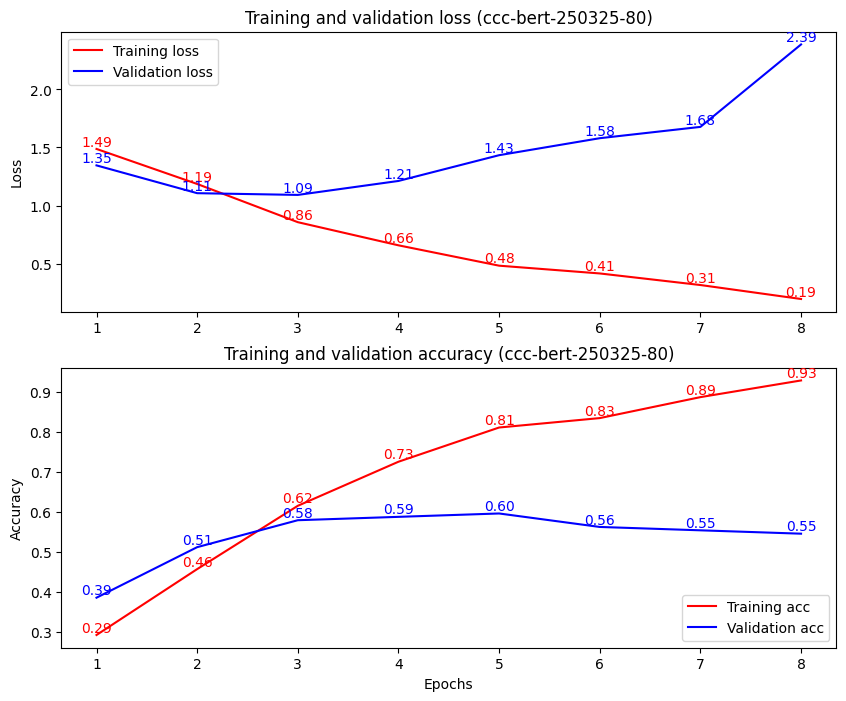

In [10]:
history_dict = training_history.history

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title(f'Training and validation loss ({dataset_name})')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Add value labels for loss
for x, y in zip(epochs, loss):
    plt.text(x, y, f"{y:.2f}", color='red', ha='center', va='bottom')
for x, y in zip(epochs, val_loss):
    plt.text(x, y, f"{y:.2f}", color='blue', ha='center', va='bottom')

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title(f'Training and validation accuracy ({dataset_name})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Add value labels for accuracy
for x, y in zip(epochs, acc):
    plt.text(x, y, f"{y:.2f}", color='red', ha='center', va='bottom')
for x, y in zip(epochs, val_acc):
    plt.text(x, y, f"{y:.2f}", color='blue', ha='center', va='bottom')

figname = f"{dataset_name}-{datetime.now().strftime('%y%m%d-%H%M%S')}.png"
plt.savefig(f"/kaggle/working/{figname}", dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Export model for inference
if accuracy > 0.8:
    saved_model_path = '/kaggle/output/{}_model'.format(dataset_name.replace('/', '_'))
    best_model.save(saved_model_path, include_optimizer=False)